# Titanic passenger survival predictor using an artifical neural network

To test different approaches to neural networks, different functions of ReLU and sigmoids were used to see what would work the best. This was done by just manually changing them in the cross validation and final model 

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import keras
import time
import random

from keras.models import Sequential
from keras.layers import Dense

import re

Using TensorFlow backend.


In [3]:
def cross_validation_split(dataset, folds=10):
    np.random.seed(int(time.time()))
    #creates the folds for validation
    a = np.floor(np.linspace(0,folds-.01,num=dataset.shape[0]))
    random.shuffle(a)
    #adding the folds into the dataset DataFrame
    dataset['fold'] = a 
    return dataset

In [4]:
train = pd.read_csv('train.csv')
test = pd.read_csv('test.csv')

In [5]:
dataset = pd.concat([train, test], sort=False, ignore_index=True)

In [6]:
dataset

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0.0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1.0,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1.0,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1.0,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0.0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S
...,...,...,...,...,...,...,...,...,...,...,...,...
1304,1305,NaN,3,"Spector, Mr. Woolf",male,NaN,0,0,A.5. 3236,8.0500,NaN,S
1305,1306,NaN,1,"Oliva y Ocana, Dona. Fermina",female,39.0,0,0,PC 17758,108.9000,C105,C
1306,1307,NaN,3,"Saether, Mr. Simon Sivertsen",male,38.5,0,0,SOTON/O.Q. 3101262,7.2500,NaN,S
1307,1308,NaN,3,"Ware, Mr. Frederick",male,NaN,0,0,359309,8.0500,NaN,S


In [7]:
dataset.isnull().mean().sort_values(ascending=False)

Cabin          0.774637
Survived       0.319328
Age            0.200917
Embarked       0.001528
Fare           0.000764
Ticket         0.000000
Parch          0.000000
SibSp          0.000000
Sex            0.000000
Name           0.000000
Pclass         0.000000
PassengerId    0.000000
dtype: float64

In [8]:
dataset['Fare'].fillna(dataset['Fare'].mean(), inplace=True)
dataset['Embarked'] = dataset['Embarked'].fillna('S')
dataset['Age'].fillna(dataset['Age'].mean(), inplace=True)

In [9]:
dataset.drop(['Ticket'], axis=1, inplace=True) #has numbers and letters, and i dont think it would be useful
dataset.drop(['Cabin'], axis=1, inplace=True) #has too many missing
dataset.drop(['Name'], axis=1, inplace=True) #sex, and class is recorded elsewahere, so im dropping

In [10]:
dataset.isnull().sum()

PassengerId      0
Survived       418
Pclass           0
Sex              0
Age              0
SibSp            0
Parch            0
Fare             0
Embarked         0
dtype: int64

In [11]:
dataset

,PassengerId,Survived,Pclass,Sex,Age,SibSp,Parch,Fare,Embarked
0,1,0.0,3,male,22.000000,1,0,7.2500,S
1,2,1.0,1,female,38.000000,1,0,71.2833,C
2,3,1.0,3,female,26.000000,0,0,7.9250,S
3,4,1.0,1,female,35.000000,1,0,53.1000,S
4,5,0.0,3,male,35.000000,0,0,8.0500,S
...,...,...,...,...,...,...,...,...,...
1304,1305,NaN,3,male,29.881138,0,0,8.0500,S
1305,1306,NaN,1,female,39.000000,0,0,108.9000,C
1306,1307,NaN,3,male,38.500000,0,0,7.2500,S
1307,1308,NaN,3,male,29.881138,0,0,8.0500,S


In [12]:
dataset['Embarked'] = dataset['Embarked'].map({'S':1,'C':0,'Q':2})
dataset['Sex'] = dataset['Sex'].map({'female':0,'male':1})

In [13]:
train = dataset[:len(train)]
test = dataset[len(train):]
test.drop(labels=['Survived'], axis=1, inplace=True)

/opt/anaconda3/lib/python3.7/site-packages/pandas/core/frame.py:3997: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  errors=errors,


In [14]:
train['Survived'] = train['Survived'].astype(int)

/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


In [15]:
y=train.Survived
X=train.drop('Survived', axis=1)

In [16]:
pre = pd.Series(yPredT.flatten)

NameError: name 'yPredT' is not defined

In [17]:
trian = cross_validation_split(train)

/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  import sys


In [61]:
trian = cross_validation_split(train)
for num_neurons in range(1,10):
    accT = []
    accV = []
    for i in range(10):
        #data splitting
        data_train = train.loc[train.fold != i,:]
        data_valid = trian.loc[train.fold == i,:]
                
        y_train = data_train.Survived
        x_train = data_train.drop('Survived', axis=1)
        y_valid = data_valid.Survived
        x_valid = data_valid.drop('Survived', axis=1)
        
        model = Sequential()
        model.add(Dense(num_neurons, input_dim=x_train.shape[1], activation='relu'))
        #model.add(Dense(output_dim = 4, init = 'uniform', activation = 'relu'))
        model.add(Dense(output_dim = 2, init = 'uniform', activation = 'relu'))
        model.add(Dense(1, activation='sigmoid'))
        model.compile(optimizer = 'adam', loss = 'binary_crossentropy', metrics = ['accuracy'])
        model.fit(x_train, y_train, epochs=1000,verbose=0,batch_size=64)
        
        yPredT = model.predict(x_train)
        guess = []
        for val in yPredT:
            if val >= 0.5:
                guess.append(1)
            else:
                guess.append(0)
        outT = sum(y_train==guess)/len(guess)
        
        yPredV = model.predict(x_valid)
        guess = []
        for val in yPredV:
            if val >= 0.5:
                guess.append(1)
            else:
                guess.append(0)
        outV = sum(y_valid==guess)/len(guess)
        
        accT.append(outT)
        accV.append(outV)
        
    print(num_neurons, '; Trian Accuracy : ', np.array(accT).mean())
    print(num_neurons, '; Validation Accuracy : ', np.array(accV).mean())

/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  import sys
/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:18: UserWarning: Update your `Dense` call to the Keras 2 API: `Dense(activation="relu", units=2, kernel_initializer="uniform")`


1 ; Trian Accuracy :  0.7089305450481163
1 ; Validation Accuracy :  0.7004993757802748
2 ; Trian Accuracy :  0.7074582582246008
2 ; Validation Accuracy :  0.7047940074906367
3 ; Trian Accuracy :  0.6904766797114579
3 ; Validation Accuracy :  0.685892634207241
4 ; Trian Accuracy :  0.7097020245889645
4 ; Validation Accuracy :  0.6845568039950061
5 ; Trian Accuracy :  0.7756635253314903
5 ; Validation Accuracy :  0.7429837702871411
6 ; Trian Accuracy :  0.746233822435173
6 ; Validation Accuracy :  0.7071535580524344
7 ; Trian Accuracy :  0.6589545175762217
7 ; Validation Accuracy :  0.6463420724094882
8 ; Trian Accuracy :  0.7152905812871068
8 ; Validation Accuracy :  0.7016229712858927
9 ; Trian Accuracy :  0.6722721909334031
9 ; Validation Accuracy :  0.685892634207241


In [84]:
num_neurons = 5 #from the cross-validation

y_train = train.Survived
x_train = train.drop('Survived', axis=1)
x_train = x_train.drop('fold', axis=1)
x_val = test

model = Sequential()
model.add(Dense(num_neurons, input_dim=x_train.shape[1], activation='relu'))
#model.add(Dense(output_dim = 4, init = 'uniform', activation = 'relu'))
model.add(Dense(output_dim = 2, init = 'uniform', activation = 'relu'))
model.add(Dense(1, activation='sigmoid'))
model.compile(optimizer = 'adam', loss = 'binary_crossentropy', metrics = ['accuracy'])
model.fit(x_train, y_train, epochs=1000,verbose=0,batch_size=64)

y_pred = model.predict(x_val)

#train['Prediction'] = y_pred

#print('Accuracy on test data: ', sum(train['Prediction']==train['Survived'])/sum(train['Survived']))

/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:11: UserWarning: Update your `Dense` call to the Keras 2 API: `Dense(activation="relu", units=2, kernel_initializer="uniform")`
  # This is added back by InteractiveShellApp.init_path()


In [85]:
#y_pred

In [86]:
valid = pd.read_csv('test_result.csv')

In [87]:
series = []
for val in y_pred:
    if val >= 0.5:
        series.append(1)
    else:
        series.append(0)

In [88]:
valid['pred'] = series

In [89]:
sum(valid.pred==valid.Survived)/len(series)

0.8708133971291866

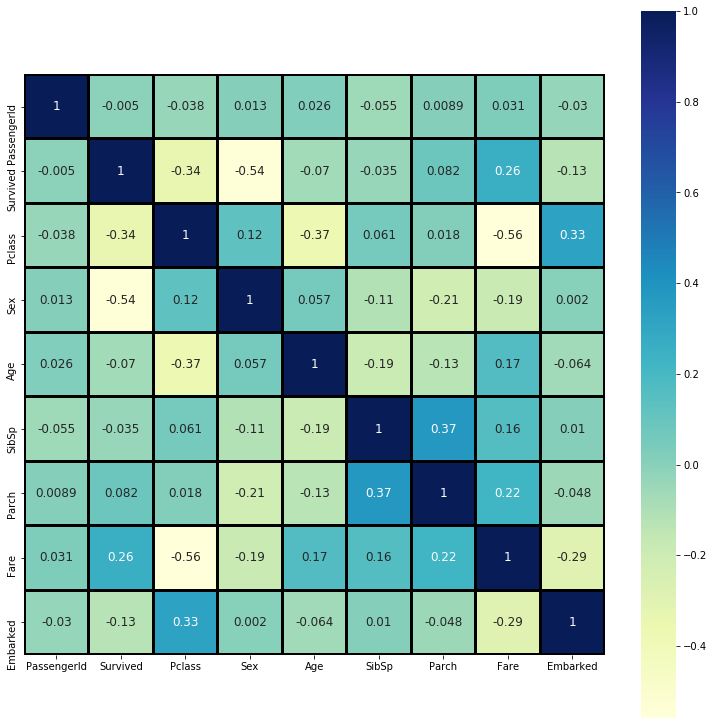

In [128]:
fig, axs = plt.subplots(nrows=1, figsize=(13, 13))
sns.heatmap(dataset.corr(), annot=True, square=True, cmap='YlGnBu', linewidths=2, linecolor='black', annot_kws={'size':12})


In [152]:
len(series)

418